## Import Packages

In [ ]:
import gc
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torchvision
from torchvision import models
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder

# For the progress bar.
from tqdm.auto import tqdm

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# [Hint]: "ConcatDataset" may be possibly useful 
from torch.utils.data import ConcatDataset, DataLoader, Dataset

## Configuration

In [ ]:
your_student_ID = 'b08611035'

In [ ]:
def configuration() -> dict:
    # configuration
    config = {
        'seed': 1126,                          # random seed
        'batch_size': 2048,                    # Batch size for training, validation, and testing.                 
        'num_epoch' : 30,                      # number of training epoch
        'optimizer': 'Adam',                   # optimization algorithm (optimizer in torch.optim)
        'optim_hparas': {                      # hyper-parameters for the optimizer (depends on which optimizer you are using)
            'lr': 0.001,                       # learning rate 
            'weight_decay' : 1e-5,             # weight_decay
             # 'momentum': 0.9                 # momentum for SGD
        },
        'lr_scheduler': 'ReduceLROnPlateau',   # [Hint] learning rate scheduler
        'lr_scheduler_paras': {
            'patience' : 10,                   # patience for ReduceLROnPlateau
            'factor': 0.1,                     # Reduction factor for ReduceLROnPlateau
        },
        'model_path': 'model.ckpt',            # the path where checkpoint saved
        'num_classes': 10,                     # number of class
        'csv_path': your_student_ID + '_pred.csv',   # csv path       
        'num_workers': 2
    }
    return config

In [ ]:
def print_config(config:dict) -> None:
    print('[Info] Print config...')
    for key, value in config.items():
        print('-- {}: {}'.format(key, value))

In [ ]:
# Print the configuration
print_config(configuration())

[Info] Print config...
-- seed: 1126
-- batch_size: 2048
-- num_epoch: 30
-- optimizer: Adam
-- optim_hparas: {'lr': 0.001, 'weight_decay': 1e-05}
-- lr_scheduler: ReduceLROnPlateau
-- lr_scheduler_paras: {'patience': 10, 'factor': 0.1}
-- model_path: model.ckpt
-- num_classes: 10
-- csv_path: b08611035_pred.csv
-- num_workers: 2


## Data Augmentation

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for digit recognition.

train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 32)
    transforms.Resize((32, 32)),
    # transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

# You 'may' need to do 'some' proper augmentations in testing and validation.
# Or you can simply resize the PIL image and transform it into Tensor.
valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    # it don't really need data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

## MNIST-M


In [ ]:
# If permission denied, you can try other link to download the dataset.
'''
Link 1: https://drive.google.com/file/d/1e_StZNXWXC0jt0Er64lKCDzSwBTuL5bs/view?usp=sharing
LInk 2: https://drive.google.com/file/d/1ifdsbLhhuZIsNVpAf3vALiMPM_XjW1PY/view?usp=sharing
Link 3: https://drive.google.com/file/d/1t_4Vro_dKxoLfzU6q1o5WUVqt91E2tpz/view?usp=sharing
'''
num_link = 3
if int(your_student_ID[-1]) % num_link == 0:
    !gdown --id '1e_StZNXWXC0jt0Er64lKCDzSwBTuL5bs' --output digit.zip
elif int(your_student_ID[-1]) % num_link == 1:
    !gdown --id '1ifdsbLhhuZIsNVpAf3vALiMPM_XjW1PY' --output digit.zip
elif int(your_student_ID[-1]) % num_link == 2:
    !gdown --id '1t_4Vro_dKxoLfzU6q1o5WUVqt91E2tpz' --output digit.zip

!unzip digit.zip
!ls 

串流輸出內容已截斷至最後 5000 行。
  inflating: digit/test/08494.png    
  inflating: digit/test/08506.png    
  inflating: digit/test/08513.png    
  inflating: digit/test/08514.png    
  inflating: digit/test/08531.png    
  inflating: digit/test/08533.png    
  inflating: digit/test/08535.png    
  inflating: digit/test/08536.png    
  inflating: digit/test/08552.png    
  inflating: digit/test/08569.png    
  inflating: digit/test/08573.png    
  inflating: digit/test/08579.png    
  inflating: digit/test/08594.png    
  inflating: digit/test/08597.png    
  inflating: digit/test/08599.png    
  inflating: digit/test/08621.png    
  inflating: digit/test/08634.png    
  inflating: digit/test/08649.png    
  inflating: digit/test/08660.png    
  inflating: digit/test/08667.png    
  inflating: digit/test/08697.png    
  inflating: digit/test/08704.png    
  inflating: digit/test/08705.png    
  inflating: digit/test/08714.png    
  inflating: digit/test/08720.png    
  inflating: digit/test/08724

## Dataset

In [ ]:
class Dataset(Dataset):
    def __init__(self, data_path=None, label_path=None, transform=None, target_transform=None):
        
        self.data_path = data_path 
        self.label_path = label_path 
        
        self.transform = transform
        self.target_transform = target_transform
        
        ## preprocess files
        self.preprocess(self.data_path, self.label_path)
        

    def __len__(self) -> "length":
        return len(self.data_files)

    def __getitem__(self, idx):
        data_file = self.data_files[idx]
        img_path = os.path.join(self.data_path, data_file)
        image = Image.open(img_path) # plt.imread(img_path)
 
        if self.transform:
            image = self.transform(image)
        
        if self.label_path is None:
            return image, -1, data_file
        
        label = self.file_labels['label'][self.file_labels['image_name'] == data_file].iloc[0]
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label, data_file
    
    def preprocess(self, data_path, label_path) -> None:
        self.data_files = os.listdir(data_path)
        self.data_files.sort()
  
        if label_path is not None:
            self.file_labels = pd.read_csv(label_path)

In [ ]:
class Data:
    def __init__(self, train_batch_size = 128, 
                 data_path = './digit/train', label_path = './digit/train.csv', 
                 train_transform = None, valid_transform = None) -> "Dataset initial":
        
        # Training
        self.train_dataset = Dataset(data_path = data_path, label_path = label_path, transform = train_transform)
        
        # Validation
        valid_data_path = data_path.replace('train', 'valid')
        
        valid_label_path = label_path
        if label_path is not None:
            valid_label_path = label_path.replace('train', 'valid')

        self.valid_dataset = Dataset(data_path = valid_data_path, label_path = valid_label_path, transform = valid_transform)
        
        # Testing
        test_data_path = data_path.replace('train', 'test')
        
        test_label_path = label_path
        if label_path is not None:
            if int(your_student_ID[-1]) % 3 == 1:
                test_label_path = label_path.replace('train', 'sample')
            else:
                test_label_path = label_path.replace('train', 'test')
        
        self.test_dataset = Dataset(data_path = test_data_path, label_path = test_label_path, transform = valid_transform)
               
        print(len(self.train_dataset))
        print(len(self.valid_dataset))
        print(len(self.test_dataset))

In [ ]:
data = Data(train_transform = train_transform, valid_transform = valid_transform)

45000
15000
10000


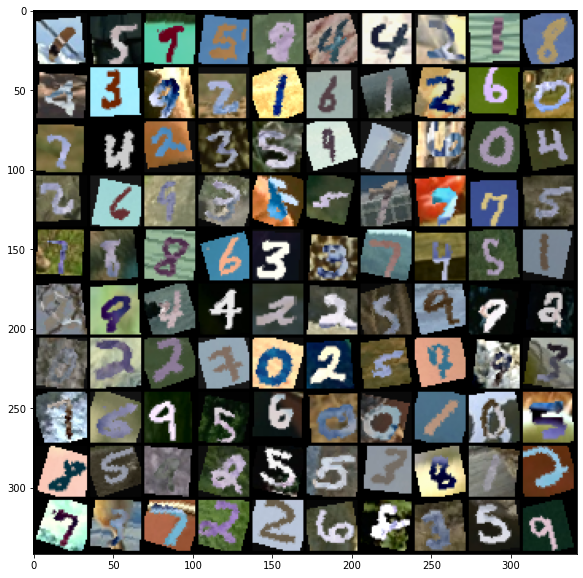

In [ ]:
images = [(data.train_dataset[i * 450][0] + 1) / 2 for i in range(100)]
grid_img = torchvision.utils.make_grid(images, nrow = 10)
plt.figure(figsize = (10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

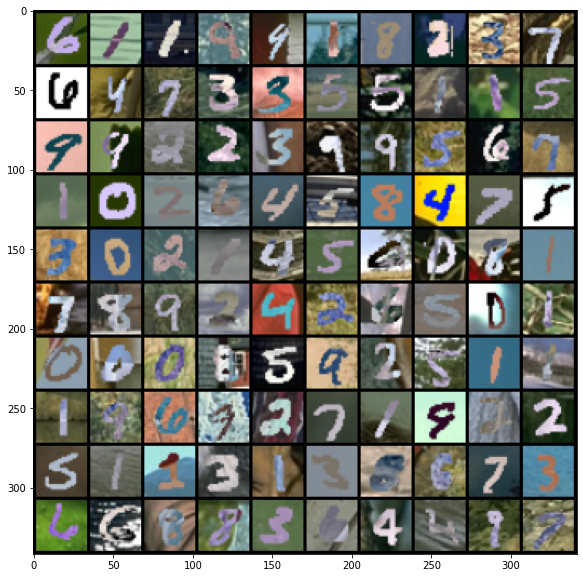

In [ ]:
images = [(data.test_dataset[i * 100][0] + 1) / 2 for i in range(100)]
grid_img = torchvision.utils.make_grid(images, nrow = 10)
plt.figure(figsize = (10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Utilities

In [ ]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# check device
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dim: [3, 32, 32]
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
           nn.Linear(128, 10)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 32, 32]
        # output: [batch_size, 10]
        # Extract features by convolutional layers.
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dim: [3, 32, 32]
        self.fc_layers = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 32, 32]
        # output: [batch_size, 10]
        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## Training

In [ ]:
def Train(config, train_set, valid_set=None, model=None, record=None):
    # Fix seeds and device
    same_seeds(config['seed'])
    device = get_device()
    
    # Construct data loaders.
    train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, 
                              pin_memory=True, num_workers=config['num_workers'])
    if valid_set:
        valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, 
                                  pin_memory=True, num_workers=config['num_workers'])

    # Print config
    print_config(config)
    
    # Create model, define a loss function, and optimizer
    if not model:
        # Initialize a model, and put it on the device specified.
        model = CNN().to(device)
        # [Hint]: model = getattr(torchvision.models, config['backbone'])().to(device)
    
    if not record: 
        record = {
            'loss': {'train': [], 'valid': []},      # for recording loss
            'acc': {'train': [], 'valid': []},      # for recording accuracy
        }
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
        
    # Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    # learning rate scheduler
    scheduler = getattr(torch.optim.lr_scheduler, config['lr_scheduler'])(optimizer, **config['lr_scheduler_paras']) 
    
    best_acc = -1.0
    lr = config['optim_hparas']['lr']
    
    # The number of training epochs.
    n_epochs = config['num_epoch']
    for epoch in range(n_epochs):
        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()
        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):
            # A batch consists of image data and corresponding labels.
            imgs, labels, data_file = batch
            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))
            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))
            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()
            # Compute the gradients for parameters.
            loss.backward()
            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            # Update the parameters with computed gradients.
            optimizer.step()
            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc.item())

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        record['loss']['train'].append(train_loss)
        record['acc']['train'].append(train_acc)
        
        # Print the information.
        print(f"[ Train | {epoch + 1:04d}/{n_epochs:04d} ] loss = {train_loss:.6f}, acc = {train_acc:.6f}")
        
        if valid_set:
            # ---------- Validation ----------
            # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
            model.eval()
            # These are used to record information in validation.
            valid_loss = []
            valid_accs = []

            # Iterate the validation set by batches.
            for batch in tqdm(valid_loader):
                # A batch consists of image data and corresponding labels.
                imgs, labels, data_file = batch
                # We don't need gradient in validation.
                # Using torch.no_grad() accelerates the forward process.
                with torch.no_grad():
                    logits = model(imgs.to(device))
                # We can still compute the loss (but not the gradient).
                loss = criterion(logits, labels.to(device))
                # Compute the accuracy for current batch.
                acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
                # Record the loss and accuracy.
                valid_loss.append(loss.item())
                valid_accs.append(acc.item())

            # The average loss and accuracy for entire validation set is the average of the recorded values.
            valid_loss = sum(valid_loss) / len(valid_loss)
            valid_acc = sum(valid_accs) / len(valid_accs)

            record['loss']['valid'].append(valid_loss)
            record['acc']['valid'].append(valid_acc)

            # Print the information.
            print(f"[ Valid | {epoch + 1:04d}/{n_epochs:04d} ] loss = {valid_loss:.6f}, acc = {valid_acc:.6f}")

            # if the model improves, save a checkpoint at this epoch
            if valid_acc > best_acc:
                best_acc = valid_acc
                torch.save(model.state_dict(), config['model_path'])
                print(f'[Info] Saving model with Train Acc: {train_acc:.6f} | val acc: {valid_acc:.6f}')
            
            scheduler.step(valid_loss)
        else:
            # If you don't have validation set, simply save the model with the highest training accuracy 
            if train_acc > best_acc:
                best_acc = train_acc
                torch.save(model.state_dict(), config['model_path'])
                print(f'[Info] Saving model with Train Acc: {train_acc:.6f}')
                
            scheduler.step(train_loss)
        
        curr_lr = optimizer.param_groups[0]['lr']
        if curr_lr != lr:
            print(f'[Info] Current learning rate: {curr_lr:.8f}')
            lr = curr_lr
            
    print('Best Acc:', str(best_acc)[:7])
    print('Learning rate:', lr)
    return record

In [ ]:
# Fix seeds and device
config = configuration()
same_seeds(config['seed'])

# "cuda" only when GPUs are available.
device = get_device()
model = CNN().to(device)

# Print model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 16, 16]           9,248
              ReLU-8           [-1, 32, 16, 16]               0
       BatchNorm2d-9           [-1, 32, 16, 16]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
          Dropout-11             [-1, 32, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          18,496
             ReLU-13             [-1, 64, 8, 8]               0
      BatchNorm2d-14             [-1, 6

In [ ]:
config['num_epoch'] = 10
config['num_workers'] = 0
config['batch_size'] = 256
record = Train(config=config, train_set=data.train_dataset, valid_set=data.valid_dataset, model=model)

[Info] Print config...
-- seed: 1126
-- batch_size: 256
-- num_epoch: 10
-- optimizer: Adam
-- optim_hparas: {'lr': 0.001, 'weight_decay': 1e-05}
-- lr_scheduler: ReduceLROnPlateau
-- lr_scheduler_paras: {'patience': 10, 'factor': 0.1}
-- model_path: model.ckpt
-- num_classes: 10
-- csv_path: b08611035_pred.csv
-- num_workers: 0


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0001/0010 ] loss = 1.346679, acc = 0.535571


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0001/0010 ] loss = 0.290013, acc = 0.908456
[Info] Saving model with Train Acc: 0.535571 | val acc: 0.908456


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0002/0010 ] loss = 0.430898, acc = 0.861841


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0002/0010 ] loss = 0.180446, acc = 0.942584
[Info] Saving model with Train Acc: 0.861841 | val acc: 0.942584


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0003/0010 ] loss = 0.293953, acc = 0.905304


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0003/0010 ] loss = 0.139609, acc = 0.952564
[Info] Saving model with Train Acc: 0.905304 | val acc: 0.952564


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0004/0010 ] loss = 0.226940, acc = 0.926820


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0004/0010 ] loss = 0.110964, acc = 0.962516
[Info] Saving model with Train Acc: 0.926820 | val acc: 0.962516


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0005/0010 ] loss = 0.200387, acc = 0.936459


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0005/0010 ] loss = 0.109296, acc = 0.965847
[Info] Saving model with Train Acc: 0.936459 | val acc: 0.965847


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0006/0010 ] loss = 0.178150, acc = 0.944335


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0006/0010 ] loss = 0.090632, acc = 0.970712
[Info] Saving model with Train Acc: 0.944335 | val acc: 0.970712


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0007/0010 ] loss = 0.162043, acc = 0.947942


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0007/0010 ] loss = 0.089977, acc = 0.971151
[Info] Saving model with Train Acc: 0.947942 | val acc: 0.971151


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0008/0010 ] loss = 0.156554, acc = 0.950162


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0008/0010 ] loss = 0.083903, acc = 0.972963
[Info] Saving model with Train Acc: 0.950162 | val acc: 0.972963


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0009/0010 ] loss = 0.147526, acc = 0.953158


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0009/0010 ] loss = 0.075291, acc = 0.974834
[Info] Saving model with Train Acc: 0.953158 | val acc: 0.974834


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 0010/0010 ] loss = 0.135614, acc = 0.956189


  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid | 0010/0010 ] loss = 0.076285, acc = 0.975566
[Info] Saving model with Train Acc: 0.956189 | val acc: 0.975566
Best Acc: 0.97556
Learning rate: 0.001


## Plot Learning Curve

In [ ]:
def plot_learning_curve(record, y_lim, y_label='', title=''):
    ''' Plot learning curve of your CNN (train & valid loss) '''
    figure(figsize=(6, 4))
    x_1 = list(range(len(record['train'])))
    plt.plot(record['train'], c='tab:red', label='train')
    if record['valid']:
        x_2 = list(range(len(record['valid'])))
        plt.plot(record['valid'], c='tab:cyan', label='valid')
    plt.ylim(0.0, y_lim)
    plt.xlabel('training steps')
    plt.ylabel(y_label)
    plt.title('Learning curve {}'.format(title))
    plt.legend()
    plt.show()

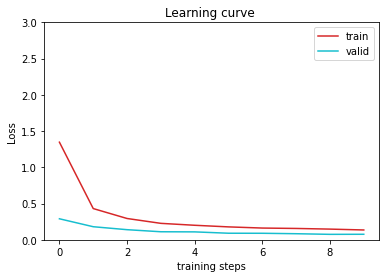

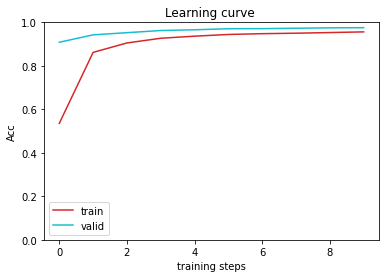

In [ ]:
plot_learning_curve(record['loss'], y_lim=3.0, y_label='Loss')
plot_learning_curve(record['acc'], y_lim=1.0, y_label='Acc')

## Validation

In [ ]:
def validation(loader_valid, model):
    # switch to eval mode
    model.eval()
    # These are used to record information in validation.
    valid_accs = []
    valid_labels = []
    valid_prediction = []

    # Iterate the validation set by batches.
    for batch in tqdm(loader_valid):
        # A batch consists of image data and corresponding labels.
        imgs, labels, data_file = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # Compute the accuracy for current batch.
        pred = logits.argmax(dim=-1)
        acc = (pred == labels.to(device)).float().mean()
        valid_labels.extend(labels)
        valid_prediction.extend(pred.cpu())
        # Record the loss and accuracy.
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid ] acc = {valid_acc:.6f}")

    return valid_labels, valid_prediction

loader_valid = DataLoader(data.valid_dataset, batch_size=config['batch_size'], shuffle=False, 
                                  pin_memory=True, num_workers=config['num_workers'])
valid_labels, valid_prediction = validation(loader_valid, model)

  0%|          | 0/59 [00:00<?, ?it/s]

[ Valid ] acc = 0.975566


## Confusion Matrix

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# define function
def plot_confusion_matrix(cm):
    ncm = []
    title = 'Confusion Matrix'
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.5) 
    sns.heatmap(df_cm, annot=True, linewidths=0, annot_kws={"size": 12}, cmap="Blues", fmt='g')
    plt.xlabel('predict') # 橫軸是 prediction
    plt.ylabel('truth')   # 縱軸是 truth
    plt.title(title)
    plt.show()


# TODO: Use confusion_matrix & plot_confusion_matrix 


ModuleNotFoundError: No module named 'seaborn'

## Testing / Making prediction file

In [ ]:
def inference(loader_test, model, output_file_name='prediction.csv'):
    outputs = []
    datafiles = []

    # switch to eval mode
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets, datafile) in enumerate(loader_test, 1):
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            preds = model(inputs)
            _, output = preds.topk(1, 1, True, True)
            outputs.extend(list(output.reshape(-1).cpu().detach().numpy()))
            datafiles.extend(list(datafile))

    output_file = dict()
    output_file['image_name'] = datafiles
    output_file['label'] = outputs
    
    output_file = pd.DataFrame.from_dict(output_file)
    output_file.to_csv(output_file_name, index = False)
    

In [ ]:
loader_test = DataLoader(data.test_dataset, batch_size=config['batch_size'], shuffle=False, 
                                  pin_memory=True, num_workers=config['num_workers'])
inference(loader_test, model)